## Imports

In [29]:
%%writefile requirements.txt

lightgbm==4.5.0
xgboost==2.1.1
scikit-learn=1.4.2


Overwriting requirements.txt


In [30]:
%%capture

!pip install -r requirements.txt

In [31]:
%%writefile -a myimports.py

print(f"\n---> Commencing Imports")

from gc import collect
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import display_html, clear_output
clear_output()
import os, sys, logging, re, joblib, ctypes, shutil
from copy import deepcopy

# General library imports
from os import path, walk, getpid
from psutil import Process
from collections import Counter
from itertools import product
import ctypes
libc=ctypes.CDLL("libc.so.6")

from IPython.display import display_html, clear_output
from pprint import pprint
from functools import partial
from copy import deepcopy
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from numpy.typing import ArrayLike, NDArray
import polars as pl
import polars.selectors as cs
from polars.testing import assert_frame_equal

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style, init
from tqdm.notebook import tqdm


Appending to myimports.py


In [32]:
%%writefile -a myimports.py

# Importing model and pipeline specifics
from category_encoders import OrdinalEncoder, OneHotEncoder

# Pipeline specifics
from sklearn.preprocessing import (RobustScaler,
MinMaxScaler,
StandardScaler,
FunctionTransformer as FT,
PowerTransformer,
)
from sklearn.impute import SimpleImputer as SI
from sklearn.model_selection import (
    RepeatedStratifiedKFold as RSKF,
    StratifiedKFold as SKF,
    KFold,
    GroupKFold as GKF,
    RepeatedKFold as RKF,
    PredefinedSplit as PDS,
    cross_val_score,
    cross_val_predict
)
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold as VT
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import (BaseEstimator,TransformerMixin, RegressorMixin, clone)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import Ridge
from sklearn.metrics import ( 
    root_mean_squared_error as rmse,
    mean_absolute_error as mae
    )
from sklearn.ensemble import (
    RandomForestRegressor as RFR,
    ExtraTreesRegressor as ETR,
    HistGradientBoostingRegressor as HGBR)

# Importing model packages
import xgboost as xgb, lightgbm as lgb
from xgboost import XGBRegressor as XGBR, QuantileDMatrix
from lightgbm import log_evaluation, early_stopping, LGBMRegressor as LGBMR
from catboost import CatBoostRegressor as CBR, Pool

# Importing ensemble and tuning packages
import optuna
from optuna import Trial, trial, create_study
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler, CmaEsSampler
optuna.logging.disable_default_handler()


Appending to myimports.py


In [33]:
%%writefile -a myimports.py

# setting rc parameters in seaborn for plots and graphs
sns.set_theme(
    {
        "axes.facecolor":"#ffffff",
        "figure.facecolor":"#ffffff",
        "axes.edgecolor": "#000000",
        "grid.color":"#ffffff",
        "font.family":["Cambria"],
        "axes.labelcolor":"#000000",
        "xtick.color":"#000000",
        "ytick.color":"#000000",
        "grid.linewidth":0.75,
        "grid.linestyle":"--",
        "axes.titlecolor":"#0099e6",
        "axes.titlesize":8.5,
        "axes.labelweight":"bold",
        "legend.fontsize":7.0,
        "legend.title_fontsize":7.0,
        "font.size":7.5,
        "xtick.labelsize":7.5,
        "ytick.labelsize":7.5
    }
        )

# color printing
def PrintColor(text:str,color=Fore.BLUE,style=Style.BRIGHT):
    print(style+color+text+Style.RESET_ALL)

# Checking package versions
import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk, pandas as pd, polars as pl
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | CatBoost = {cb.__version__}")
print(f"---> Sklearn = {sk.__version__} | Pandas = {pd.__version__} | Polars = {pl.__version__}")

Appending to myimports.py


In [34]:
%%writefile -a myimports.py
 
class MyLogger:
    """
    This class helps to supress logs in lightgbm and optuna
    """
    def init(self,logging_lbl:str):
        self.logger=logging.getLogger(logging_lbl)
        self.logger.setLevel(logging.ERROR)

    def info(self,message):
        pass

    def warning(self,message):
        pass

    def error(self,message):
        self.logger.error(message)

# Customizing logging for xgboost

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logger=logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
formatter=logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

stdout_handler=logging.StreamHandler(sys.stdout)
stdout_handler.setLevel(logging.INFO)
stdout_handler.setFormatter(formatter)

file_handler=logging.FileHandler(f"xgb_optimize.log")
file_handler.setLevel(logging.ERROR)
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)
logger.addHandler(stdout_handler)

class XGBLogging(xgb.callback.TrainingCallback):
    """
    This class is design for custom logging in xgboost
    This is to be used inside XGBoost callback
    """
    def __init__(self,epoch_log_interval=100):
        self.epoch_log_interval=epoch_log_interval

    def after_interaction(
            self,model,epoch:int,evals_log:xgb.callback.TrainingCallback.EvalsLog
    ):
        if self.epoch_log_interval<=0:
            pass

        elif (epoch%self.epoch_log_interval==0):
            for data,metric in evals_log.items():
                for metric_name, log in metric.items():
                    score=log[-1][0] if isinstance(log[-1], tuple) else log[-1]
                    logger.info(f"XGBLogging epoch {epoch} dataset {data} {metric_name} {score}")

        return False







Appending to myimports.py


In [35]:
%%time
exec(open('myimports.py','r').read())
print()


---> XGBoost = 2.1.1 | LightGBM = 4.5.0 | CatBoost = 1.2.7
---> Sklearn = 1.5.2 | Pandas = 2.2.3 | Polars = 1.8.2

CPU times: user 22 ms, sys: 28 μs, total: 22.1 ms
Wall time: 30.4 ms


In [36]:
%%writefile -a training.py

# Configuration class
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    """

    # Data preparation
    version_nb         =1
    model_id           ="V1_2"
    model_label        ="ML"

    test_req           =False
    test_sample_frac   =1000

    gpu_switch         ="OFF"
    state              =42
    target             =f"bg+1:00"
    grouper            =f"p_num"

    ip_path            =f'/mnt/c/Users/anush/Documents/Competitions/BrisT1D Blood Glucose Prediction/inputs'
    op_path            =f'/mnt/c/Users/anush/Documents/Competitions/BrisT1D Blood Glucose Prediction/outputs'

    # Model Training
    pstprcs_oof        =False
    pstprcs_train      =False
    pstprcs_test       =False
    ML                 =True
    test_preds_req     =True

    pseudo_lbl_req      =False
    pseudolbl_up        =0.975
    pseudolbl_low       =0.0

    n_splits        =3 if test_req else 5
    n_repeats       =1
    nbrnd_erly_stp  =100
    mdlcv_mthd      ='GKF'

    #Ensemble
    ensemble_req=True
    metric_obj='minimize'

    # Global variables for plotting
    grid_specs={
        'visible':True,
        'which':"both",
        "linestyle":"--",
        "color":"lightgrey",
        "linewidth":0.75
        }
    
    title_specs={
        'fontsize':9,
        'fontweight':"bold",
        'color':"#992600"
                 }
cv_selector=\
{
    "RKF":RKF(n_splits=CFG.n_splits,n_repeats=CFG.n_repeats,random_state=CFG.state),
    "RSKF":RSKF(n_splits=CFG.n_splits,n_repeats=CFG.n_repeats,random_state=CFG.state),
    "SKF":SKF(n_splits=CFG.n_splits,shuffle=True,random_state=CFG.state),
    "KF":KFold(n_splits=CFG.n_splits,shuffle=True,random_state=CFG.state),
    "GKF":GKF(n_splits=CFG.n_splits)
}

PrintColor(f"\n---> Configuration done !\n")
collect()


Appending to training.py


## PreProcessing


In [37]:

%%writefile -a training.py

def XformCols(df:pd.DataFrame):
    """
    This function do the following.
    * Create time components on time column
    * Removes special characters in column labels

    """

    df["hour_nb"]   =pd.to_datetime(df['time']).dt.hour
    df["minute_nb"] =pd.to_datetime(df['time']).dt.minute
    df.columns      =df.columns.str.replace("\W",'',regex=True)

    return df.drop("time", axis=1,errors='ignore')



Appending to training.py


In [38]:
%%capture

exec(open('training.py','r').read())

train=pd.read_csv(os.path.join(CFG.ip_path,'train.csv'),index_col="id",low_memory=False)
test=pd.read_csv(os.path.join(CFG.ip_path,'test.csv'),index_col="id",low_memory=False)
sub_f1=pd.read_csv(os.path.join(CFG.ip_path,'sample_submission.csv'),index_col="id")

if CFG.test_req:
    train=train.groupby(CFG.grouper).sample(n=CFG.test_sample_frac)

train.index=range(len(train))

_=utils.CleanMemory()

NameError: name 'utils' is not defined

In [39]:
%%time

PrintColor(f"---> Shapes= {train.shape} {test.shape} {sub_f1.shape}")

Xtrain=train.drop([CFG.target,CFG.grouper],axis=1, errors="ignore")
ytrain=train[CFG.target]
ygrp=train[CFG.grouper]
Xtest=test.drop([CFG.target,CFG.grouper],axis=1,errors="ignore")

# Defining the data pipeline
xform=Pipeline(
    [
        ("XformCols",FT(XformCols)),
        ("Xform",ColumnTransformer([
            ("SI",SI(strategy="mean"),make_column_selector(dtype_include=np.number)),
            ("OE",make_pipeline(*[SI(strategy="constant",fill_value="missing"),OrdinalEncoder(return_df=False)]),make_column_selector(pattern="activity"))
                                    ],
                                    remainder="passthrough",
                                    verbose_feature_names_out=False,))
    ],verbose=False).set_output(transform="pandas")

Xtrain=xform.fit_transform(Xtrain,ytrain)
Xtest=xform.transform(Xtest)

PrintColor(f"---> Shapes= {Xtrain.shape} {ytrain.shape} {Xtest.shape} {sub_f1.shape}")

# Initializing CV scheme
cv=cv_selector[CFG.mdlcv_mthd]

# Initializing CV folds across training data
folds=np.zeros(len(Xtrain))
for fold_nb,(train_idx,dev_idx) in enumerate(cv.split(Xtrain,ytrain,ygrp)):
    folds[dev_idx]=fold_nb
Xtrain["fold_nb"]=folds
del folds

# Adding source column for training algorithm
Xtrain["Source"]="Competition"

PrintColor(f"\nData Pipeline Strcuture\n",color=Fore.RED)
display(xform)

PrintColor(f"---> Shapes={Xtrain.shape} {ytrain.shape} {Xtest.shape} {sub_f1.shape}")
# PrintColor(python_utils.CleanMemory())

---> Shapes= (177024, 507) (3644, 506) (3644, 1)
---> Shapes= (177024, 506) (177024,) (3644, 506) (3644, 1)

Data Pipeline Strcuture



Pipeline(steps=[('XformCols',
                 FunctionTransformer(func=<function XformCols at 0x7f8c33d5c900>)),
                ('Xform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('SI', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8bcf839160>),
                                                 ('OE',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(return_df=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8bcf8393d0>)],
                                   verbose_feature_names_out=False))])

---> Shapes=(177024, 508) (177024,) (3644, 506) (3644, 1)
CPU times: user 11.1 s, sys: 1.23 s, total: 12.3 s
Wall time: 12.3 s


## Model Training

In [40]:
%%writefile -a training.py

class ModelTrainer:
    """ 
    This Class trains the provided model on train-test data and returns the predictions and fitted models
    """

    def __init__(self,
                 es_req:bool=False,
                 es:int=100,
                 target:str=CFG.target,
                 metric_lbl:str='rmse',
                 drop_cols:list=["Source","id","Id","Label",CFG.target,"fold_nb",CFG.grouper],
                 ):
        """ 
        key parameters-
        es_iter: early stopping rounds for boosted trees
        """
        drop_cols=list(set(drop_cols+[target]))

        self.es_req=es_req
        self.es_iter=es
        self.target=target
        self.drop_cols=drop_cols
        self.metric_lbl=metric_lbl

    def ScoreMetric(self,ytrue,ypred)->float:
        """ 
        This is the metric function for the competition scoring
        """
        return rmse(ytrue,ypred)
    
    def PlotFtreImp(self,
                    ftreimp:pd.Series,
                    method:str,
                    ntop:int=50,
                    title_specs:dict=CFG.title_specs,
                    **params,
                    ):
        """ 
        This functon plots the feature importance for the model provided
        """
        print()
        fig,ax=plt.subplots(1,1,figsize=(25,8))
        ftreimp.sort_values(ascending=False).head(ntop).plot.bar(ax=ax,color="blue")
        ax.set_title(f"Fearture Importances -{method}",**title_specs)

        plt.tight_layout()
        plt.show()

        print()

    def PostProcessPreds(self,ypred):
        """ 
        This method post-processes the predictions optionally
        """
        return np.clip(ypred,a_min=0,a_max=np.inf)
    

    def MakeOfflineModel(self,
                         X,y,ygrp,Xttest,mdl,method,
                         test_preds_req:bool=True,
                         ftreimp_plot_req:bool=True,
                         ntop:int=50,
                         **params):
                         
        """
        This method trains the provided model on the dataset and cross validates appropriately

        Inputs-
        X,y,ygrp        -train data components
        Xtest           -test data
        model           -model object for training
        method          -model method label
        test_preds_req  -boolean flag to extract test set predictions
        ftreimp_req     -boolean falg to plot tree feature importances
        ntop            -top n features for feature importances plot

        Returns
        oof_preds,test_preds    -prediction arrays
        fitted_models           -fitted model list for test set
        ftreimp                 -feature importance across selected features
        mdl_best_iter           -model average best iteration across folds

        """
        oof_preds=np.zeros(len(X))
        test_preds=[]
        mdl_best_iter=[]
        ftreimp=0

        scores,tr_scores,fitted_models=[],[],[]
        cv=PDS(ygrp)
        n_splits=ygrp.nunique()

        for fold_nb,(train_idx,dev_idx) in tqdm(enumerate(cv.split(X,y))):
            Xtr=X.iloc[train_idx].drop("Source",axis=1,errors="ignore")
            Xdev=X.iloc[dev_idx].query("Source=='Competition'").drop("Source",axis=1,errors="ignore")
            ytr=y.iloc[Xtr.index]
            ydev=y.iloc[Xdev.index]
            model=clone(mdl)

            if "CB" in method and self.es_req==True:
                model.fit(Xtr,ytr,
                          eval_set=[(Xdev,ydev)],
                          verbose=0,
                          early_stopping_rounds=self.es_iter
                          )
                best_iter=model.get_best_iteration()

            elif "LGB" in method and self.es_req==True:
                model.fit(Xtr,ytr,
                          eval_set=[(Xdev,ydev)],
                          callbacks=[log_evaluation(0),
                                      early_stopping(stopping_rounds=self.es_iter,
                                                     verbose=False),
                                                ],
                        )
                best_iter=model.best_iteration_

            elif "XGB" in method and self.es_req==True:
                model.fit(Xtr,ytr,
                          eval_set=[(Xdev,ydev)],
                          verbose=0,
                          )
                best_iter=model.best_iteration

            else:
                model.fit(Xtr,ytr)
                best_iter=-1

            fitted_models.append(model)
            
            try:
                ftreimp+=model.feature_importances_
            except:
                pass

            dev_preds=self.PostProcessPreds(model.predict(Xdev))
            oof_preds[Xdev.index]=dev_preds

            train_preds=self.PostProcessPreds(model.predict(Xtr))
            tr_score=self.ScoreMetric(ytr.values.flatten(),train_preds)
            score=self.ScoreMetric(ydev,dev_preds)

            scores.append(score)
            tr_scores.append(tr_score)

            nspace=15-len(method)-2 if fold_nb<=9 else 15-len(method)-1

            if self.es_req:
                PrintColor(f"{method} Fold{fold_nb} {' '*nspace} OOF = {score:.6f} | Train = {tr_score:.6f} | Iter = {best_iter:,.0f}")
            else:
                PrintColor(f"{method} Fold{fold_nb} {' '*nspace} OOF = {score:.6f} | Train = {tr_score:.6f}")

            mdl_best_iter.append(best_iter)

            if test_preds_req:
                test_preds.append(self.PostProcessPreds(model.predict(Xtest)))
            else:
                pass

        tets_preds=np.mean(np.stack(test_preds,axis=1),axis=1) 
        ftreimp=pd.Series(ftreimp,index=Xdev.columns)
        mdl_best_iter=np.uint16(np.amax(mdl_best_iter))

        if ftreimp_plot_req==True and best_iter>0:
            print()
            self.PlotFtreImp(ftreimp,method=method,ntop=ntop)
        else:
            pass

        PrintColor(f"\n---> {np.mean(scores):.6f} +- {np.std(scores):.6f} | OOF", color=Fore.RED)
        PrintColor(f"---> {np.mean(tr_scores):.6f} +- {np.std(tr_scores):.6f} | OOF",color=Fore.RED)
        
        if self.es_req==False:
            pass
        else:
            PrintColor(f"---> Max best iteration = {mdl_best_iter:,.0f}",color=Fore.RED)

        return (fitted_models,oof_preds,test_preds,ftreimp,mdl_best_iter)
    
    def MakeOnlineModel(self,X,y,Xtest,model,method,
                        test_preds_req:bool=False):
        """ 
        This method refits the model on complete train data and returns the model fitted object and predictions
        """
        try:
            model.early_stopping_rounds=None
        except:
            pass

        try:
            model.fit(X,y,verbose=0)
        except:
            model.fit(X,y)
        
        oof_preds=model.predict(X)

        if test_preds_req:
            test_preds=model.predict(Xtest[X.columns])
        else:
            test_preds=0
        return (model,oof_preds,test_preds)
    
    def MakeOfflinePreds(self,X,fitted_models):
        """
        This method creates test-set predictions for the offline model provided
        """
        test_preds=0
        n_splits=len(fitted_models)
        PrintColor(f"---> Number of splits = {n_splits}")

        for model in fitted_models:
            test_preds+=model.predict(X)/n_splits

        return test_preds
    



Appending to training.py


## Single Model Training


In [43]:
%%capture

exec(open('training.py','r').read())

try:
    l=MyLogger()
    l.init(logging_lbl="lightgbm_custom")
    lgb.register_logger(l)

except:
    pass

# Initializing model parameters
Mdl_Master={
    f"LGBM1R":LGBMR(**{
        "objective"         :"regression_l2",
        "metrics"           :"rmse",
        "device"            :"gpu" if CFG.gpu_switch=="ON" else "cpu",
        "learning_rate"     :0.035,
        "n_estimators"      :5_000,
        "max_depth"         :7,
        "num_leaves"        :60,
        "min_delta_in_leaf" :80,
        "feature_fraction"  :0.7,
        "bagging_fraction"  :0.88,
        "bagging_freq"      :6,
        "lambda_l1"         :0.001,
        "lambda_l2"         :0.1,
        "verbosity"         :-1,
        "random_state"      :CFG.state,
}),
    f"LGBM2R":LGBMR(**{
        "objective"         :"regression_l2",
        "metrics"           :"rmse",
        "device"            :"gpu" if CFG.gpu_switch=="ON" else "cpu",
        "data_sample_strategy":"goss",
        "learning_rate"     :0.0325,
        "n_estimators"      :5_000,
        "max_depth"         :6,
        "num_leaves"        :45,
        "min_delta_in_leaf" :100,
        "feature_fraction"  :0.35,
        "colsample_bytree"  :0.50,
        "lambda_l1"         :0.001,
        "lambda_l2"         :1.25,
        "verbosity"         :-1,
        "random_state"      :CFG.state,
}),
    f"XGB1R":XGBR(**{
        "objective"         :"reg:squarederror",
        "eval_metric"       :"rmse",
        "device"            :"cuda" if CFG.gpu_switch=="ON" else "cpu",
        "learning_rate"     :0.04,
        "n_estimators"      :5_000,
        "max_depth"         :7,
        "colsample_bytree"  :0.75,
        "colsample_bynode"  :0.85,
        "colsample_bylevel" :0.45,
        "reg_alpha"         :0.001,
        "reg_lambda"        :0.25,
        "verbose"           :0,
        "random_state"      :CFG.state,
        "enable_categorical":True,
        "callbacks"         :[XGBLogging(epoch_log_interval=0)],
        "early_stopping_rounds":CFG.nbrnd_erly_stp
}),
    f"CB1R":CBR(**{
        "task_type"         :"CPU",
        "loss_function"     :"RMSE",
        "eval_metric"       :"RMSE",
        "bagging_temperature":0.25,
        "colsample_bylevel" :0.40,
        "iterations"        :5_000,
        "learning_rate"     :0.04,
        "max_depth"         :7,
        "l2_leaf_reg"       :0.80,
        "min_data_in_leaf"  :70,
        "random_strength"   :0.25,
        "verbose"           :0,
        }

)}


# Initializing model outputs
OOF_Preds={}
Mdl_Preds={}
FittedModels={}
FtreImp={}
SelMdlCols={}


  0%|          | 0/4 [00:00<?, ?it/s]


---------- LGBM1R MODELTRAINING - bg+1:00 ----------



0it [00:00, ?it/s]

LGBM1R Fold0         OOF = 2.202214 | Train = 1.724697 | Iter = 282
LGBM1R Fold1         OOF = 2.198159 | Train = 1.733427 | Iter = 232
LGBM1R Fold2         OOF = 1.881405 | Train = 1.897437 | Iter = 149
LGBM1R Fold3         OOF = 2.105074 | Train = 1.621782 | Iter = 516
LGBM1R Fold4         OOF = 2.137111 | Train = 1.904784 | Iter = 77




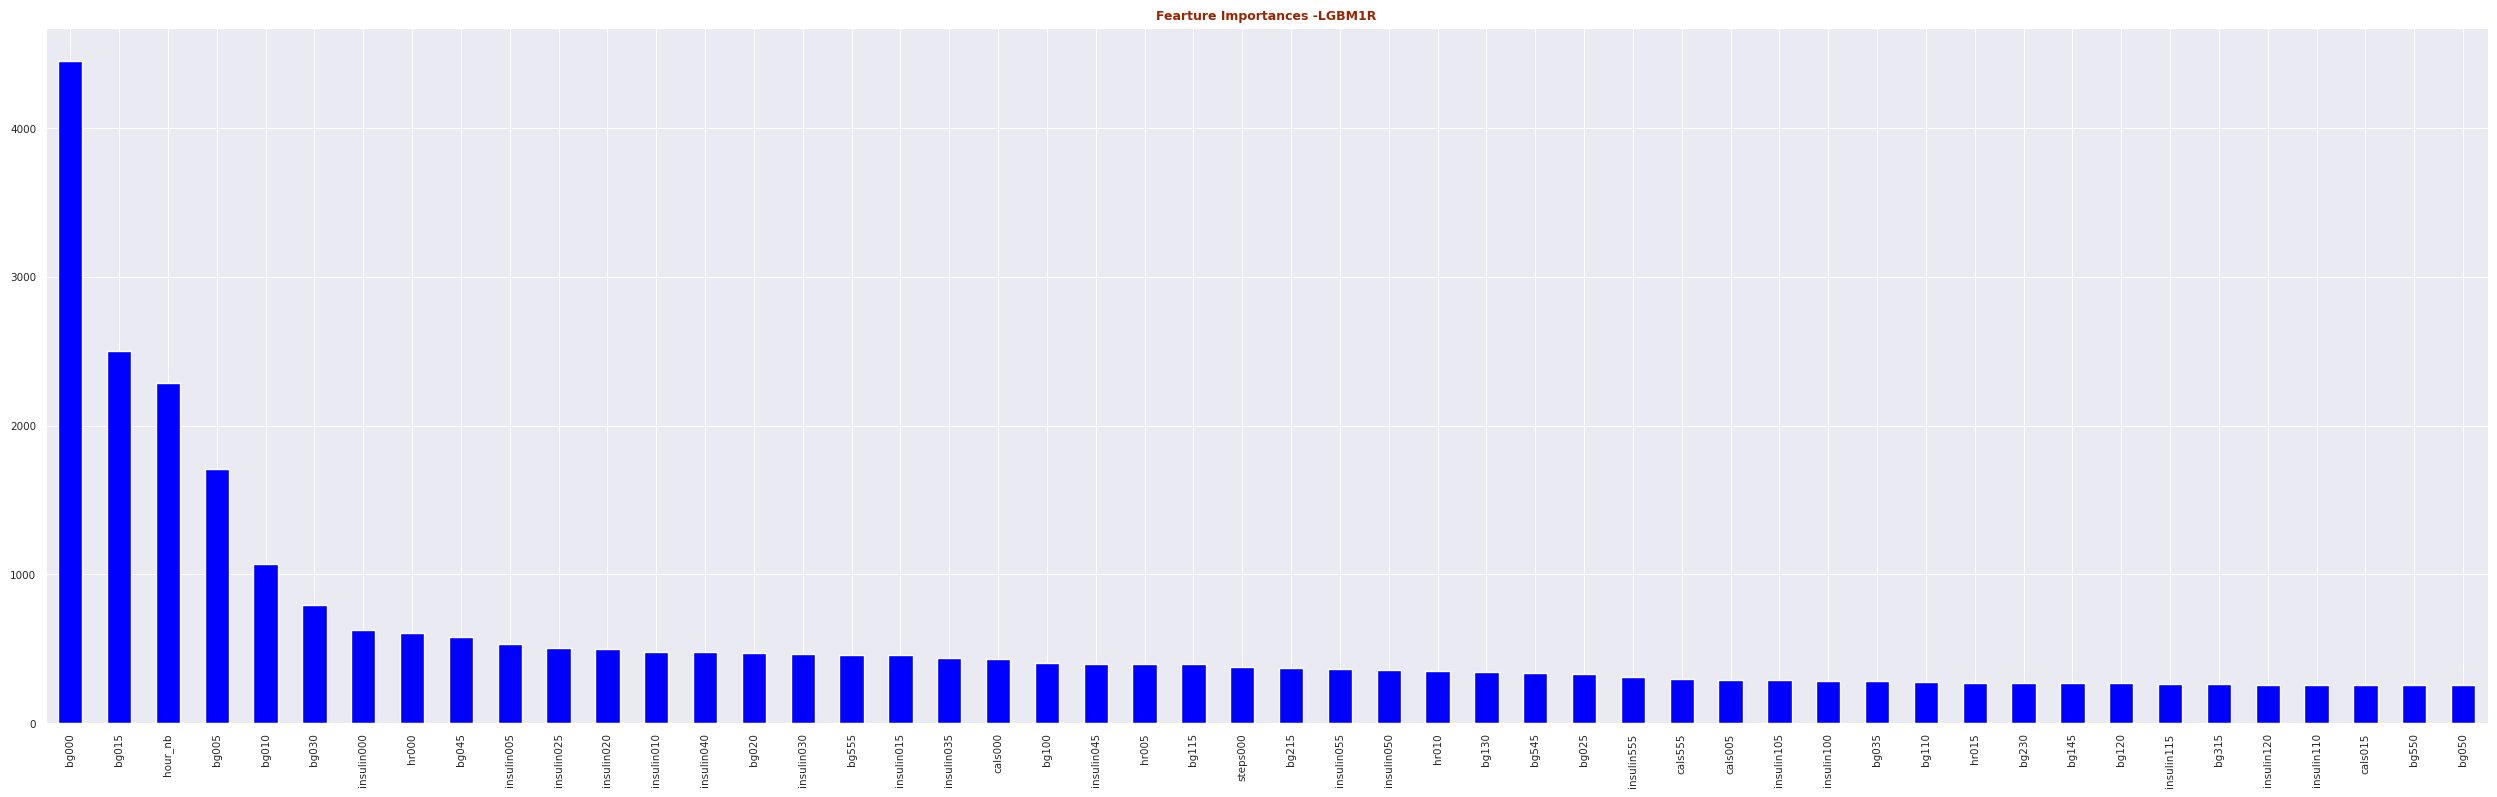



---> 2.104793 +- 0.117605 | OOF
---> 1.776425 +- 0.109141 | OOF
---> Max best iteration = 516

---------- LGBM2R MODELTRAINING - bg+1:00 ----------



0it [00:00, ?it/s]

LGBM2R Fold0         OOF = 2.213377 | Train = 1.735935 | Iter = 455
LGBM2R Fold1         OOF = 2.212346 | Train = 1.719233 | Iter = 441
LGBM2R Fold2         OOF = 1.936882 | Train = 1.929264 | Iter = 206
LGBM2R Fold3         OOF = 2.127307 | Train = 1.648894 | Iter = 760
LGBM2R Fold4         OOF = 2.200436 | Train = 1.725926 | Iter = 425




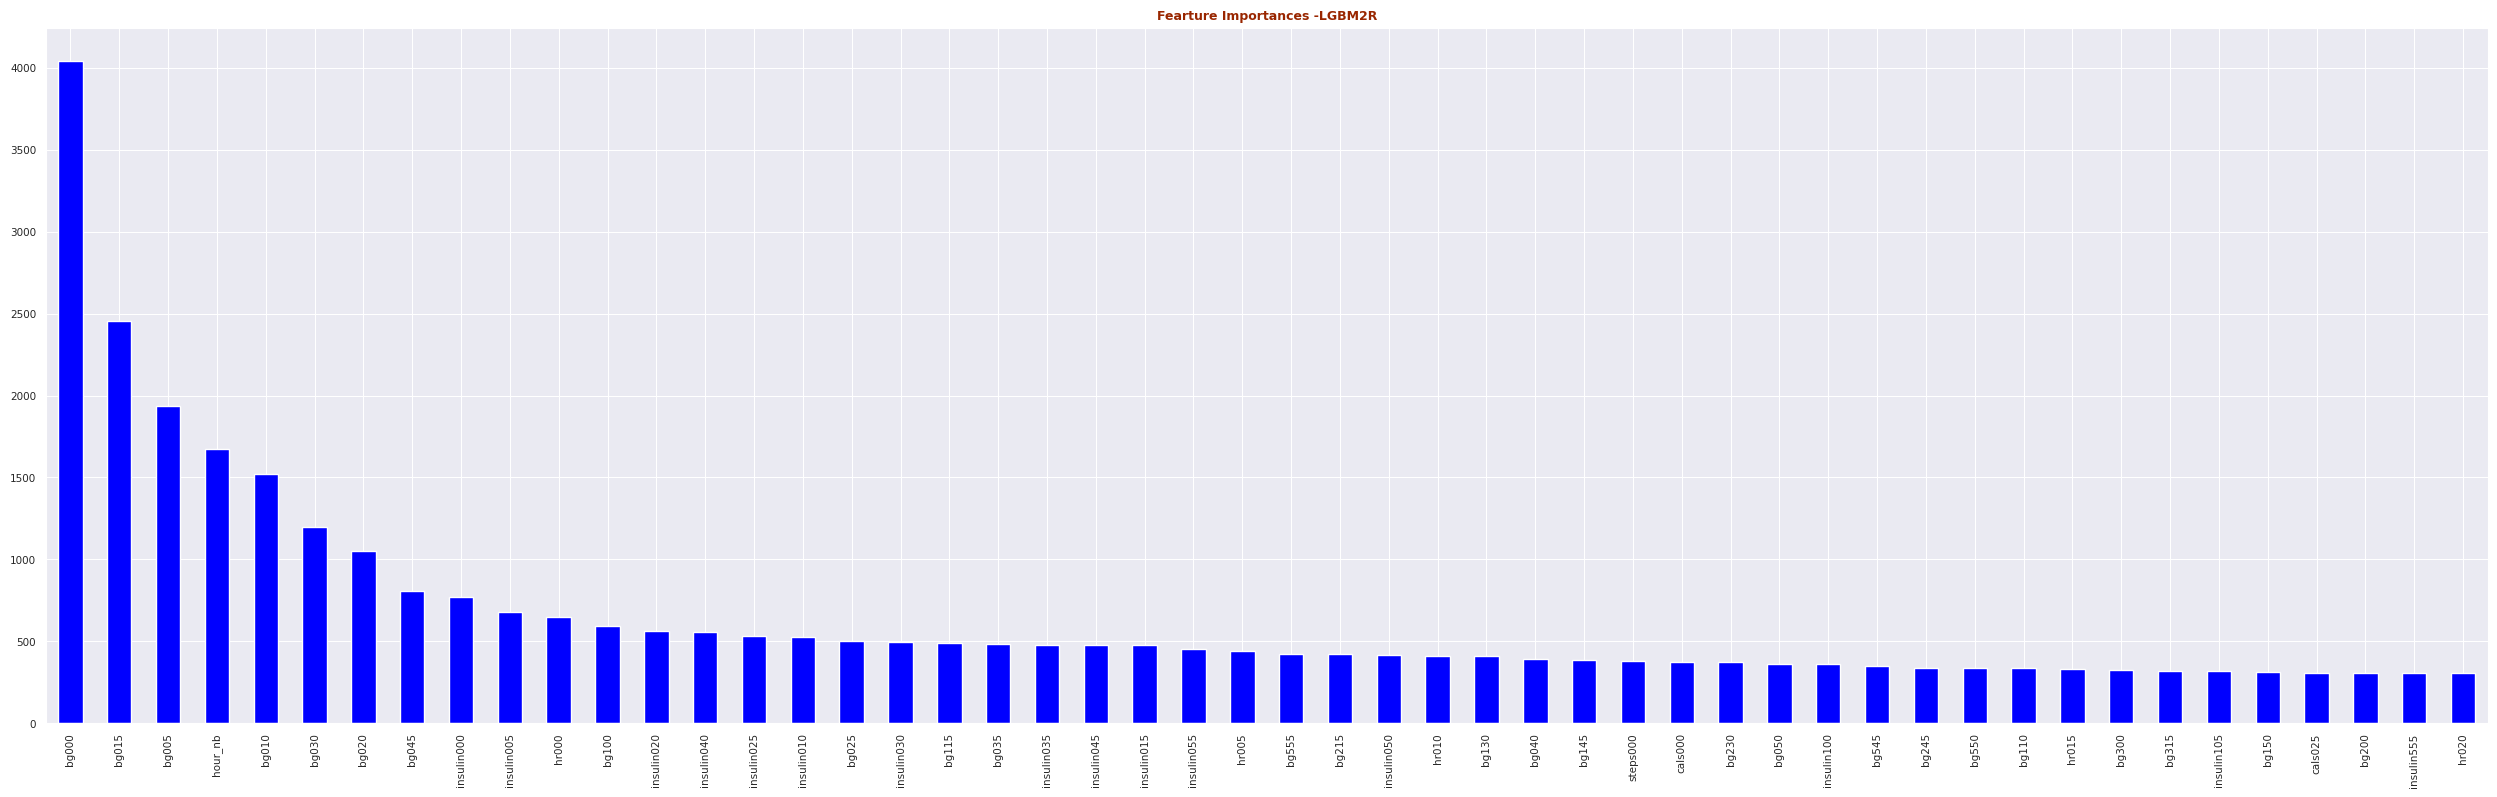



---> 2.138070 +- 0.105518 | OOF
---> 1.751850 +- 0.093877 | OOF
---> Max best iteration = 760

---------- XGB1R MODELTRAINING - bg+1:00 ----------



0it [00:00, ?it/s]

XGB1R Fold0          OOF = 2.215696 | Train = 1.636300 | Iter = 286
XGB1R Fold1          OOF = 2.183112 | Train = 1.259159 | Iter = 1,173
XGB1R Fold2          OOF = 1.899523 | Train = 1.849940 | Iter = 127
XGB1R Fold3          OOF = 2.131737 | Train = 1.561438 | Iter = 441
XGB1R Fold4          OOF = 2.224906 | Train = 1.924395 | Iter = 51




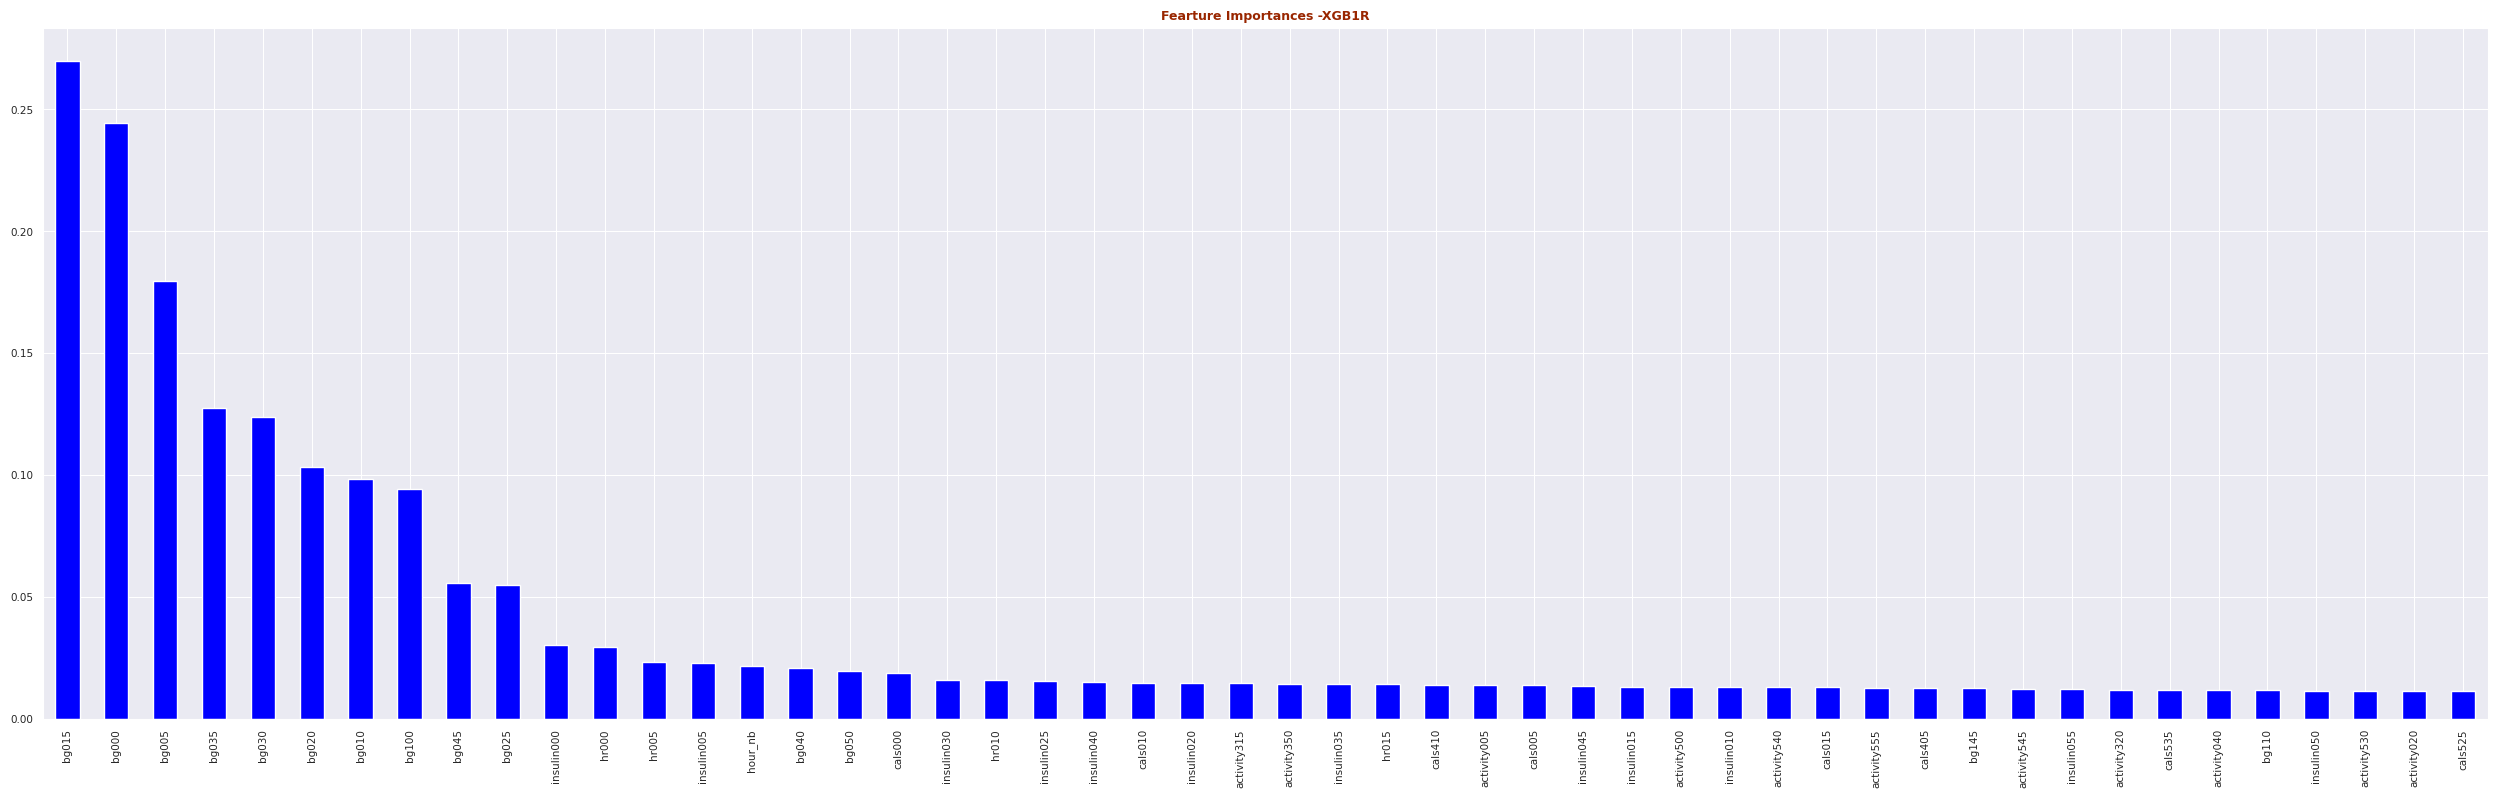



---> 2.130995 +- 0.120241 | OOF
---> 1.646246 +- 0.234941 | OOF
---> Max best iteration = 1,173

---------- CB1R MODELTRAINING - bg+1:00 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 2.203834 | Train = 1.778820 | Iter = 620
CB1R Fold1           OOF = 2.209534 | Train = 1.741150 | Iter = 705
CB1R Fold2           OOF = 1.868050 | Train = 2.024670 | Iter = 173
CB1R Fold3           OOF = 2.107479 | Train = 1.852073 | Iter = 408
CB1R Fold4           OOF = 2.193224 | Train = 2.152220 | Iter = 38




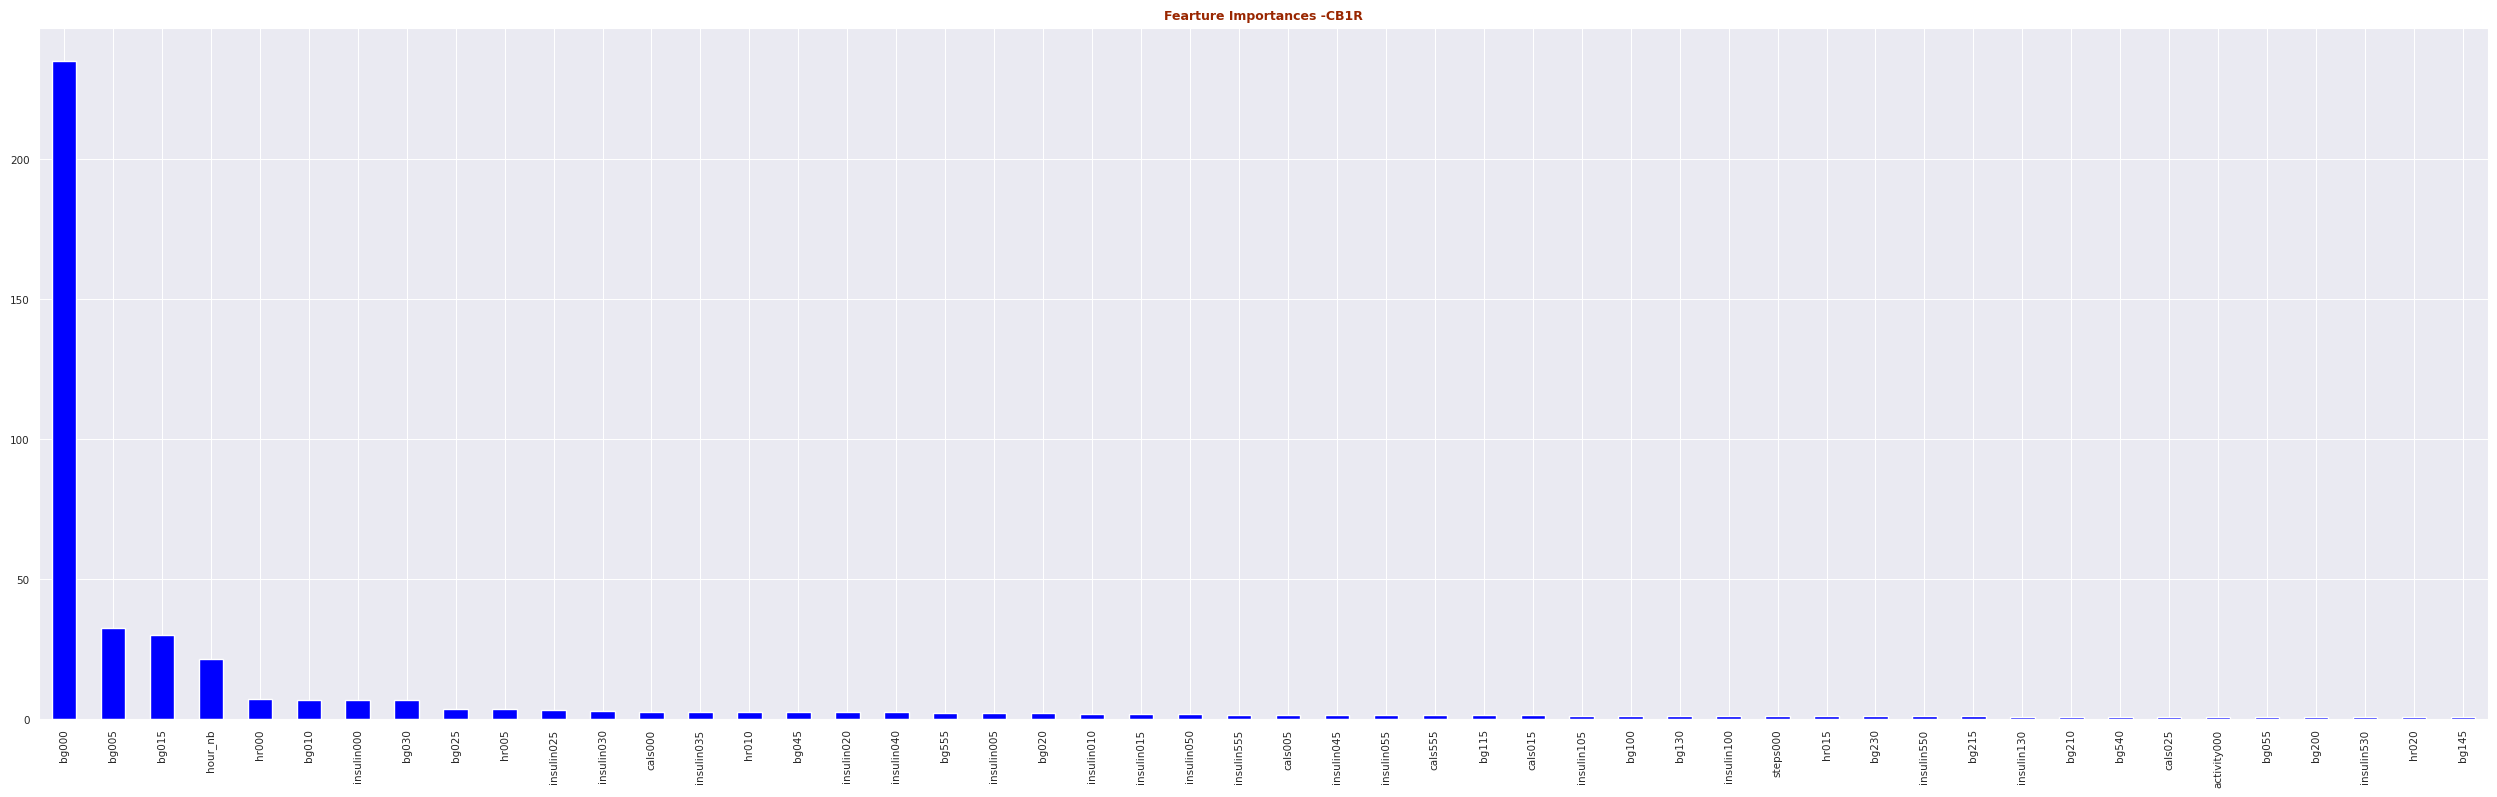



---> 2.116424 +- 0.129598 | OOF
---> 1.909787 +- 0.155495 | OOF
---> Max best iteration = 705
CPU times: user 3h 7min 59s, sys: 15min 52s, total: 3h 23min 51s
Wall time: 32min 39s


In [44]:
%%time 

# Creating CV scheme
md=ModelTrainer(es=CFG.nbrnd_erly_stp,
target=CFG.target,
es_req=True,
metric_lbl="rmse",)

for method, mdl in tqdm(Mdl_Master.items()):
    PrintColor(f"\n{'-'*10} {method} MODELTRAINING - {CFG.target} {'-'*10}\n",color=Fore.MAGENTA)
    fitted_models,oof_preds,test_preds,ftre_imp,mdl_best_iter=\
        md.MakeOfflineModel(
            Xtrain.drop([CFG.target,"fold_nb",CFG.grouper],axis=1,errors="ignore"),
            ytrain,
            Xtrain["fold_nb"],
            Xtest.drop([CFG.target,"fold_nb",CFG.grouper],axis=1,errors="ignore"),
            clone(mdl),
            method,
            test_preds_req=True,
            ftreimp_plot_req=True,
            ntop=50,

    )

    # Integrating data
    OOF_Preds[f"{method}"]=oof_preds
    Mdl_Preds[f"{method}"]=test_preds
    FtreImp[f"{method}"]=ftre_imp
    